# Классификация 128x128 + U-Net с бэкбоном

In [1]:
!unzip MOON_SEGMENTATION_BINARY.zip

Archive:  MOON_SEGMENTATION_BINARY.zip
   creating: MOON_SEGMENTATION_BINARY/
   creating: MOON_SEGMENTATION_BINARY/images/
   creating: MOON_SEGMENTATION_BINARY/images/ground/
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0001.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0002.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0003.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0004.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0005.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0006.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0007.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0008.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0009.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0010.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0011.png  
  inflating: MOON_SEGMENTATION_BINARY/images/ground/ground0012.p

In [2]:
!unzip tiny-imagenet-200\ \(1\).zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_127.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n02988304_127.JPEG  
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_432.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n02988304_432.JPEG  
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_170.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n02988304_170.JPEG  
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_465.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n02988304_465.JPEG  
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_5.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n02988304_5.JPEG  
  inflating: tiny-imagenet-200/train/n02988304/images/n02988304_259.JPEG  
  inflating: __MACOSX/tiny-imagenet-200/train/n02988304/images/._n0298830

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

TINY_IMAGENET_PATH = './tiny-imagenet-200'
MOON_DATA_PATH = './MOON_SEGMENTATION_BINARY'
CHECKPOINT_DIR = './checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using device: cuda


<a id='part1'></a>
## Часть 1: Классификатор 128×128 на Tiny ImageNet-200

### 1.1 Загрузка и подготовка данных

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training samples: 5000
Validation samples: 500


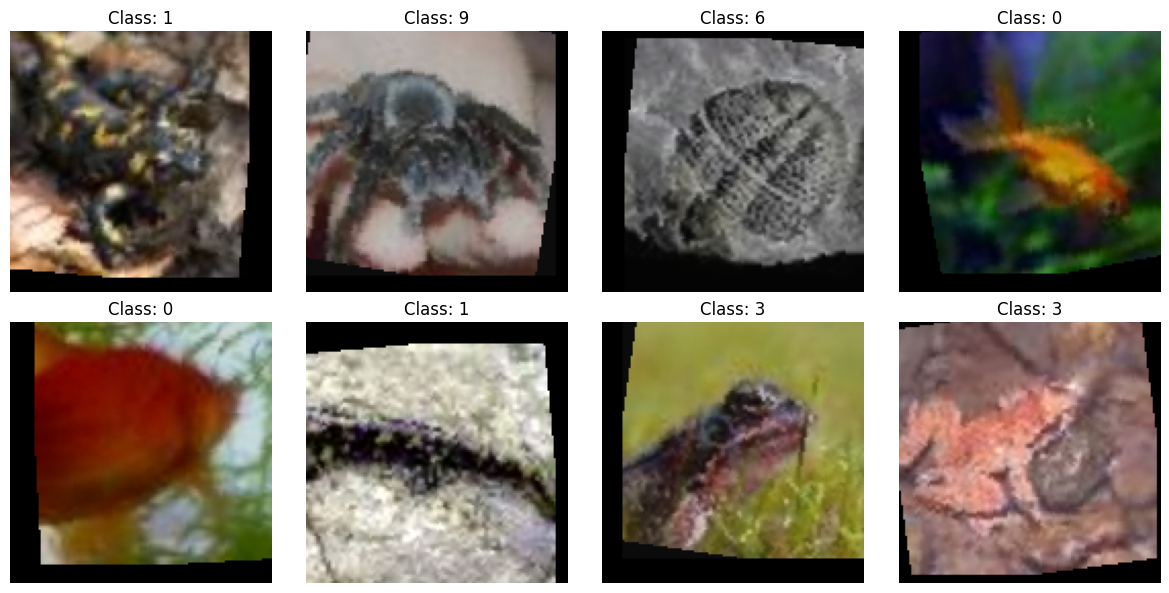

In [6]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', selected_classes=None, transform=None):
        """
        Args:
            root_dir (str): Путь к корневой директории Tiny ImageNet
            split (str): 'train', 'val' или 'test'
            selected_classes (list): Список выбранных классов (wnid)
            transform: Трансформации для изображений
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.selected_classes = selected_classes

        # Создаем маппинг класс -> индекс
        if selected_classes:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(selected_classes))}
        else:
            # Если классы не указаны, используем все
            all_classes = sorted([d.name for d in (self.root_dir / 'train').iterdir() if d.is_dir()])
            self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}

        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.samples = []
        self._load_samples()

    def _load_samples(self):
        if self.split == 'train':
            train_dir = self.root_dir / 'train'
            for class_name in self.class_to_idx.keys():
                class_dir = train_dir / class_name / 'images'
                if class_dir.exists():
                    for img_path in class_dir.glob('*.JPEG'):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))

        elif self.split in ['val', 'test']:
            val_dir = self.root_dir / 'val'
            annotations_file = val_dir / 'val_annotations.txt'
            if annotations_file.exists():
                with open(annotations_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split('\t')
                        img_name = parts[0]
                        class_name = parts[1]

                        if class_name in self.class_to_idx:
                            img_path = val_dir / 'images' / img_name
                            if img_path.exists():
                                self.samples.append((str(img_path), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

SELECTED_CLASSES = [
    'n01443537',  # goldfish
    'n01629819',  # European fire salamander
    'n01641577',  # bullfrog
    'n01644900',  # tailed frog
    'n01698640',  # American alligator
    'n01742172',  # boa constrictor
    'n01768244',  # trilobite
    'n01770393',  # scorpion
    'n01774384',  # black widow spider
    'n01774750',  # tarantula
]

num_classes = len(SELECTED_CLASSES)

train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PATH,
    split='train',
    selected_classes=SELECTED_CLASSES,
    transform=train_transform
)

val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PATH,
    split='val',
    selected_classes=SELECTED_CLASSES,
    transform=val_transform
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=4, pin_memory=True)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
    img = denormalize(img)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Class: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### 1.2 Архитектура классификатора

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        out += residual
        return self.relu(out)

class CustomClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout=0.1):
        super(CustomClassifier, self).__init__()

        # Stage 1: 128x128 -> 64x64 (32 channels)
        self.stage1 = nn.Sequential(
            ConvBlock(3, 32, kernel_size=7, stride=2, padding=3),  # 128 -> 64
            ResidualBlock(32, dropout=dropout)
        )

        # Stage 2: 64x64 -> 32x32 (64 channels)
        self.stage2 = nn.Sequential(
            ConvBlock(32, 64, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            ResidualBlock(64, dropout=dropout)
        )

        # Stage 3: 32x32 -> 16x16 (128 channels)
        self.stage3 = nn.Sequential(
            ConvBlock(64, 128, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            ResidualBlock(128, dropout=dropout)
        )

        # Stage 4: 16x16 -> 8x8 (256 channels)
        self.stage4 = nn.Sequential(
            ConvBlock(128, 256, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            ResidualBlock(256, dropout=dropout)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x1 = self.stage1(x)   # 64x64x32
        x2 = self.stage2(x1)  # 32x32x64
        x3 = self.stage3(x2)  # 16x16x128
        x4 = self.stage4(x3)  # 8x8x256

        x = self.gap(x4)      # 1x1x256
        x = x.view(x.size(0), -1)  # 256
        x = self.dropout(x)   # Dropout
        x = self.fc(x)        # num_classes

        return x

    def get_encoder_features(self, x):
        """Extract encoder features for U-Net backbone"""
        x1 = self.stage1(x)   # 64x64x32
        x2 = self.stage2(x1)  # 32x32x64
        x3 = self.stage3(x2)  # 16x16x128
        x4 = self.stage4(x3)  # 8x8x256
        return [x1, x2, x3, x4]

model = CustomClassifier(num_classes=num_classes, dropout=0.1).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,} ({total_params/1e6:.2f}M)')
print(f'Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)')
print(f'\nModel architecture:')
print(model)

dummy_input = torch.randn(2, 3, 128, 128).to(device)
dummy_output = model(dummy_input)
print(f'\nInput shape: {dummy_input.shape}')
print(f'Output shape: {dummy_output.shape}')

Total parameters: 1,963,946 (1.96M)
Trainable parameters: 1,963,946 (1.96M)

Model architecture:
CustomClassifier(
  (stage1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResidualBlock(
      (conv1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (dropout): Dropout2d(p=0.1, inplace=False)
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
  )
  (stage2): Sequential(
   

### 1.3 Обучение классификатора

In [8]:
def train_classifier(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': loss.item(),
                'acc': 100.*train_correct/train_total,
                'lr': optimizer.param_groups[0]['lr']
            })

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
            print(f'  Best model saved! (Val Acc: {val_acc:.2f}%)')
        else:
            patience_counter += 1
            print(f'  No improvement ({patience_counter}/{patience})')

        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch+1} epochs')
            break

        print()

    return history

history_classifier = train_classifier(model, train_loader, val_loader, num_epochs=10, lr=0.001)

Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]


Epoch 1/10:
  Train Loss: 2.2222, Train Acc: 19.34%
  Val Loss: 3.0638, Val Acc: 13.80%
  LR: 0.001000
  Best model saved! (Val Acc: 13.80%)



Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


Epoch 2/10:
  Train Loss: 2.0947, Train Acc: 25.62%
  Val Loss: 2.0952, Val Acc: 27.20%
  LR: 0.000969
  Best model saved! (Val Acc: 27.20%)



Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


Epoch 3/10:
  Train Loss: 2.0198, Train Acc: 30.04%
  Val Loss: 2.0295, Val Acc: 30.60%
  LR: 0.000882
  Best model saved! (Val Acc: 30.60%)



Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


Epoch 4/10:
  Train Loss: 1.9423, Train Acc: 33.28%
  Val Loss: 1.9126, Val Acc: 34.80%
  LR: 0.000748
  Best model saved! (Val Acc: 34.80%)



Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 12.50it/s]


Epoch 5/10:
  Train Loss: 1.8688, Train Acc: 36.66%
  Val Loss: 1.9959, Val Acc: 33.80%
  LR: 0.000585
  No improvement (1/10)



Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


Epoch 6/10:
  Train Loss: 1.8082, Train Acc: 39.96%
  Val Loss: 1.7282, Val Acc: 43.80%
  LR: 0.000411
  Best model saved! (Val Acc: 43.80%)



Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 12.51it/s]


Epoch 7/10:
  Train Loss: 1.7530, Train Acc: 42.44%
  Val Loss: 1.6662, Val Acc: 48.60%
  LR: 0.000248
  Best model saved! (Val Acc: 48.60%)



Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 12.02it/s]


Epoch 8/10:
  Train Loss: 1.7097, Train Acc: 45.82%
  Val Loss: 1.6462, Val Acc: 47.60%
  LR: 0.000116
  No improvement (1/10)



Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


Epoch 9/10:
  Train Loss: 1.6690, Train Acc: 47.68%
  Val Loss: 1.6258, Val Acc: 48.80%
  LR: 0.000029
  Best model saved! (Val Acc: 48.80%)



Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:00<00:00, 11.73it/s]

Epoch 10/10:
  Train Loss: 1.6580, Train Acc: 47.66%
  Val Loss: 1.6203, Val Acc: 51.20%
  LR: 0.000000
  Best model saved! (Val Acc: 51.20%)



### 1.4 Результаты и визуализация

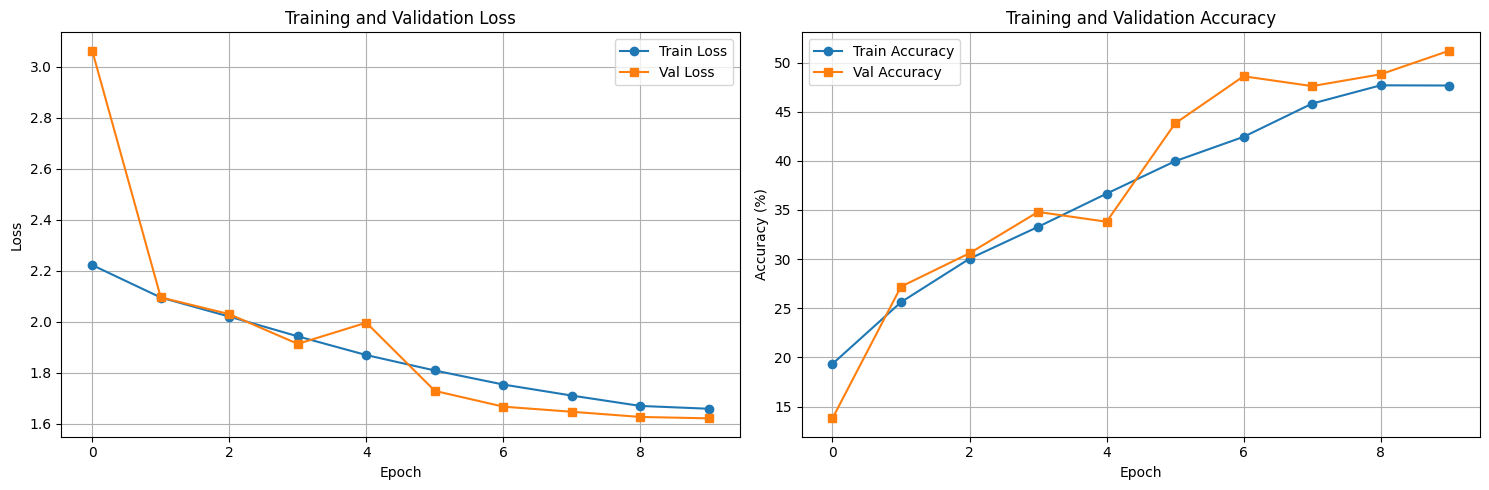

Best model loaded from epoch 10
Best validation accuracy: 51.20%


Final evaluation: 100%|██████████| 8/8 [00:00<00:00,  8.86it/s]



Final Validation Accuracy: 51.20%


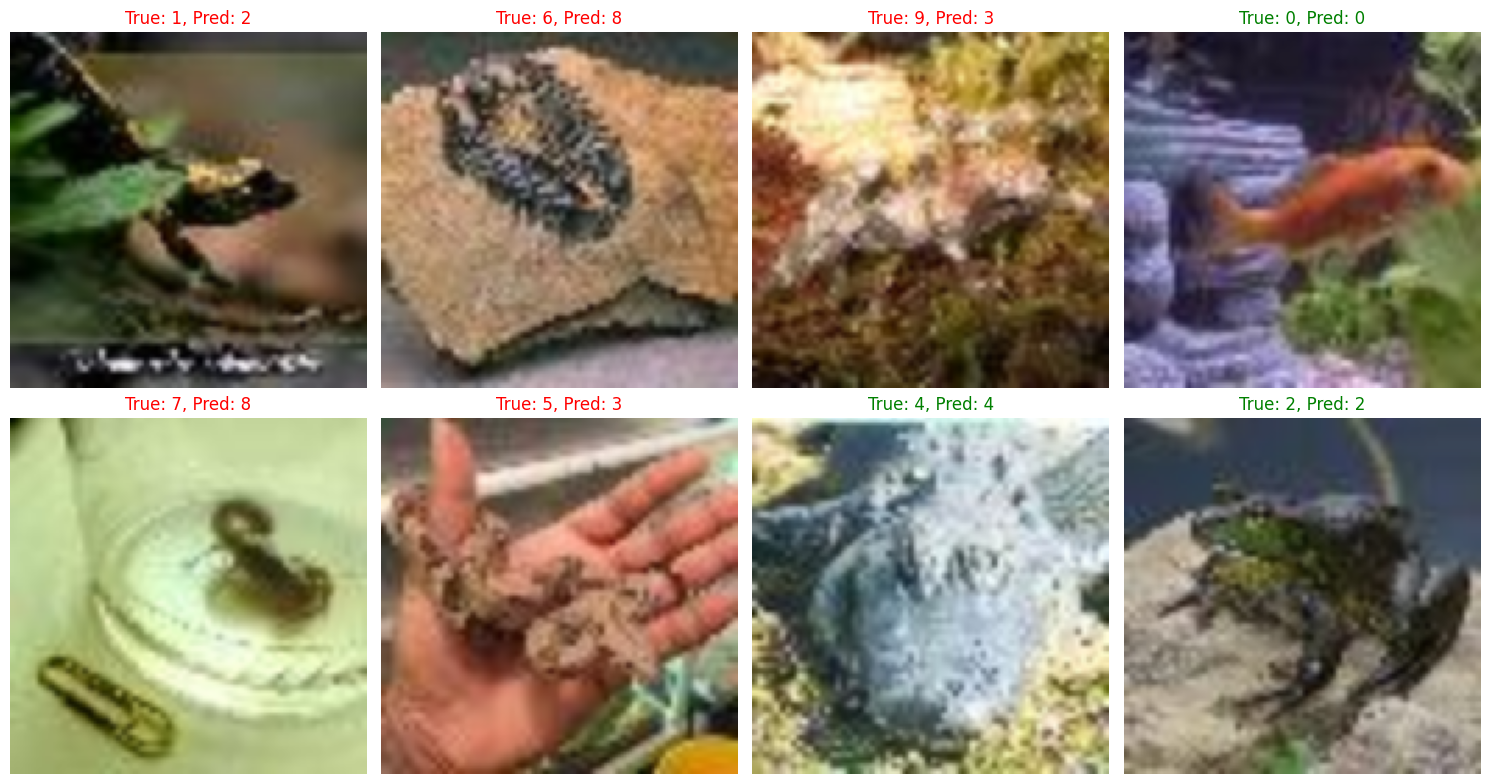

Model parameters: 1.96M
Best validation accuracy: 51.20%
Final validation accuracy: 51.20%


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_classifier['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history_classifier['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_classifier['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history_classifier['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Final evaluation'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
print(f'\nFinal Validation Accuracy: {final_acc*100:.2f}%')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
model.eval()

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        img, label = val_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        _, pred = output.max(1)

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        color = 'green' if pred.item() == label else 'red'
        ax.set_title(f'True: {label}, Pred: {pred.item()}', color=color)
        ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Model parameters: {total_params/1e6:.2f}M')
print(f'Best validation accuracy: {checkpoint["val_acc"]:.2f}%')
print(f'Final validation accuracy: {final_acc*100:.2f}%')

<a id='part2'></a>
## Часть 2: Базовая U-Net на датасете "Луна"

### 2.1 Загрузка данных сегментации

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Всего изображений: 1000
Train: 800 изображений
Val: 200 изображений


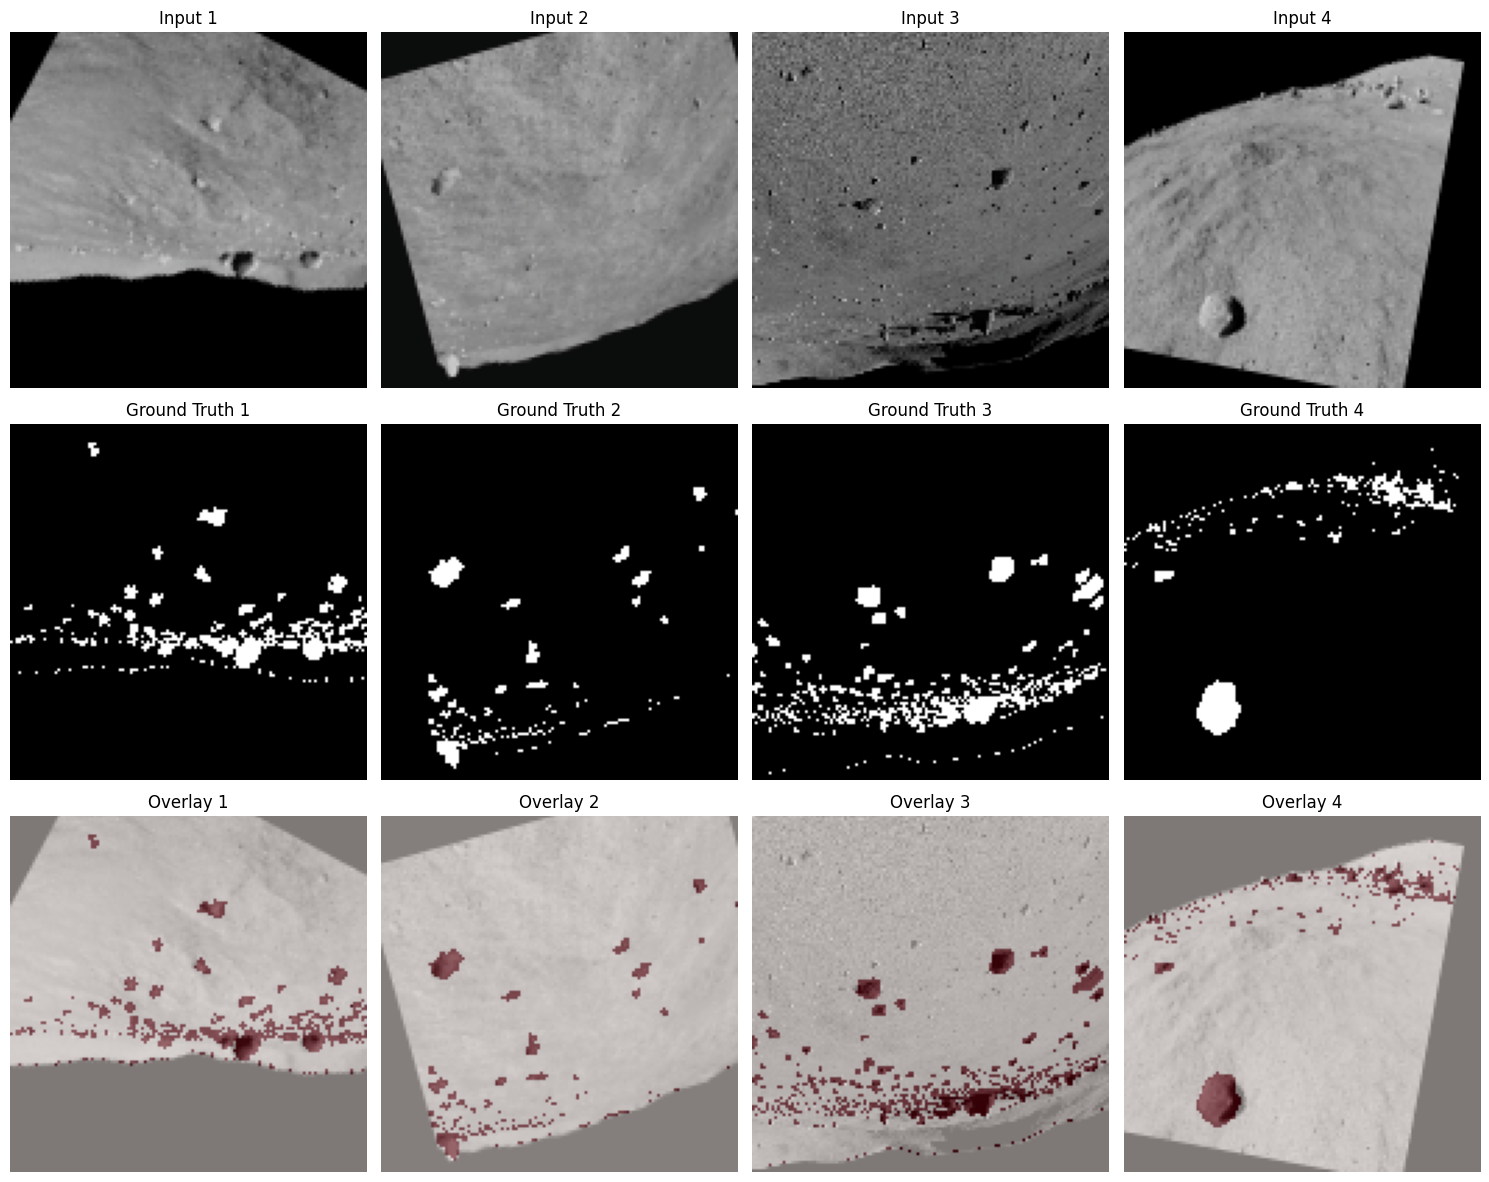

In [51]:

class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground',
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = augmentation
        self.preprocessing = preprocessing

        images_dir = os.path.join(root_dir, 'images', image_folder)
        all_images_names = os.listdir(images_dir)

        # Filter for .png files and remove extension
        self.image_ids = [img.replace('.png', '') for img in all_images_names if img.endswith('.png')]

        # If specific image_ids are provided, filter the loaded ones.
        if image_ids is not None:
            self.image_ids = [id for id in self.image_ids if id in image_ids]


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")

        # Adjusted mask_id construction based on observed file names
        # Assuming mask_id is just the number if image_id is 'renderXXXX'
        mask_number = ''.join(filter(str.isdigit, image_id))
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_number}.png")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        mask = (mask > 0).astype(np.float32)

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

train_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128), # Changed to 128x128
])

images_dir = os.path.join(MOON_DATA_PATH, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=MOON_DATA_PATH,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

batch_size = 10

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

fig, axes = plt.subplots(3, 4, figsize=(15, 12))
for i in range(4):
    img, mask = train_dataset[i*10]

    img_display = denormalize(img)
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    axes[0, i].imshow(img_display)
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    axes[1, i].axis('off')

    axes[2, i].imshow(img_display)
    axes[2, i].imshow(mask.squeeze(), cmap='Reds', alpha=0.5)
    axes[2, i].set_title(f'Overlay {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Архитектура базовой U-Net

In [62]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(DoubleConv(prev_channels, feature))
            prev_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConv(feature * 2, feature)
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)

            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)

            x = torch.cat([skip_connection, x], dim=1)

            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)

        return output


model = UNet(in_channels=3, out_channels=1, features=[64, 128, 256, 512])

test_input = torch.randn(1, 3, 256, 256)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 31,043,521
Уровней encoder: 4
Конфигурация каналов: [64, 128, 256, 512]
   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])


In [64]:
total_params_unet = sum(p.numel() for p in model.parameters())
print(total_params_unet)

31043521


### 2.3 Функции потерь и метрики

In [37]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

def calculate_iou(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def calculate_dice(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

    return dice.item()

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    correct = (pred == target).float().sum()
    total = target.numel()

    return (correct / total).item()

### 2.4 Обучение базовой U-Net

In [38]:
def train_unet(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name='unet'):
    criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                                      patience=5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou': [],
        'val_dice': [],
        'val_pixel_acc': []
    }

    best_val_iou = 0.0
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1) # Add channel dimension

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pbar.set_postfix({'loss': loss.item()})

        train_loss = train_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_iou_sum = 0.0
        val_dice_sum = 0.0
        val_pixel_acc_sum = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, masks = images.to(device), masks.to(device)
                masks = masks.unsqueeze(1) # Add channel dimension
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)

                for i in range(outputs.size(0)):
                    val_iou_sum += calculate_iou(outputs[i], masks[i])
                    val_dice_sum += calculate_dice(outputs[i], masks[i])
                    val_pixel_acc_sum += calculate_pixel_accuracy(outputs[i], masks[i])

        val_loss = val_loss / len(val_loader.dataset)
        val_iou = val_iou_sum / len(val_loader.dataset)
        val_dice = val_dice_sum / len(val_loader.dataset)
        val_pixel_acc = val_pixel_acc_sum / len(val_loader.dataset)

        scheduler.step(val_iou)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_dice'].append(val_dice)
        history['val_pixel_acc'].append(val_pixel_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val IoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Pixel Acc: {val_pixel_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]['lr']:.6f}')

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou,
                'val_dice': val_dice,
                'val_pixel_acc': val_pixel_acc,
            }, os.path.join(CHECKPOINT_DIR, f'best_{model_name}.pth'))
            print(f'Best model saved! (Val IoU: {val_iou:.4f})')

        print()

    return history

history_unet_basic = train_unet(model, train_loader, val_loader,
                                num_epochs=10, lr=0.001, model_name='unet_basic')

Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 1/10:
  Train Loss: 0.5359
  Val Loss: 0.4681
  Val IoU: 0.2471, Dice: 0.3802, Pixel Acc: 0.8929
  LR: 0.001000
Best model saved! (Val IoU: 0.2471)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Epoch 2/10:
  Train Loss: 0.4428
  Val Loss: 0.4150
  Val IoU: 0.3218, Dice: 0.4669, Pixel Acc: 0.8866
  LR: 0.001000
Best model saved! (Val IoU: 0.3218)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 3/10:
  Train Loss: 0.4072
  Val Loss: 0.3819
  Val IoU: 0.3560, Dice: 0.5002, Pixel Acc: 0.8987
  LR: 0.001000
Best model saved! (Val IoU: 0.3560)



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 4/10:
  Train Loss: 0.3961
  Val Loss: 0.4120
  Val IoU: 0.2866, Dice: 0.4250, Pixel Acc: 0.9122
  LR: 0.001000



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 5/10:
  Train Loss: 0.3752
  Val Loss: 0.3773
  Val IoU: 0.3360, Dice: 0.4804, Pixel Acc: 0.9164
  LR: 0.001000



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Epoch 6/10:
  Train Loss: 0.3764
  Val Loss: 0.3666
  Val IoU: 0.3568, Dice: 0.5029, Pixel Acc: 0.9114
  LR: 0.001000
Best model saved! (Val IoU: 0.3568)



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 7/10:
  Train Loss: 0.3715
  Val Loss: 0.3892
  Val IoU: 0.3287, Dice: 0.4707, Pixel Acc: 0.9148
  LR: 0.001000



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Epoch 8/10:
  Train Loss: 0.3648
  Val Loss: 0.3514
  Val IoU: 0.3808, Dice: 0.5298, Pixel Acc: 0.9154
  LR: 0.001000
Best model saved! (Val IoU: 0.3808)



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Epoch 9/10:
  Train Loss: 0.3667
  Val Loss: 0.3563
  Val IoU: 0.3780, Dice: 0.5281, Pixel Acc: 0.9168
  LR: 0.001000



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Epoch 10/10:
  Train Loss: 0.3573
  Val Loss: 0.3367
  Val IoU: 0.3987, Dice: 0.5471, Pixel Acc: 0.9209
  LR: 0.001000
Best model saved! (Val IoU: 0.3987)



### 2.5 Результаты и визуализация

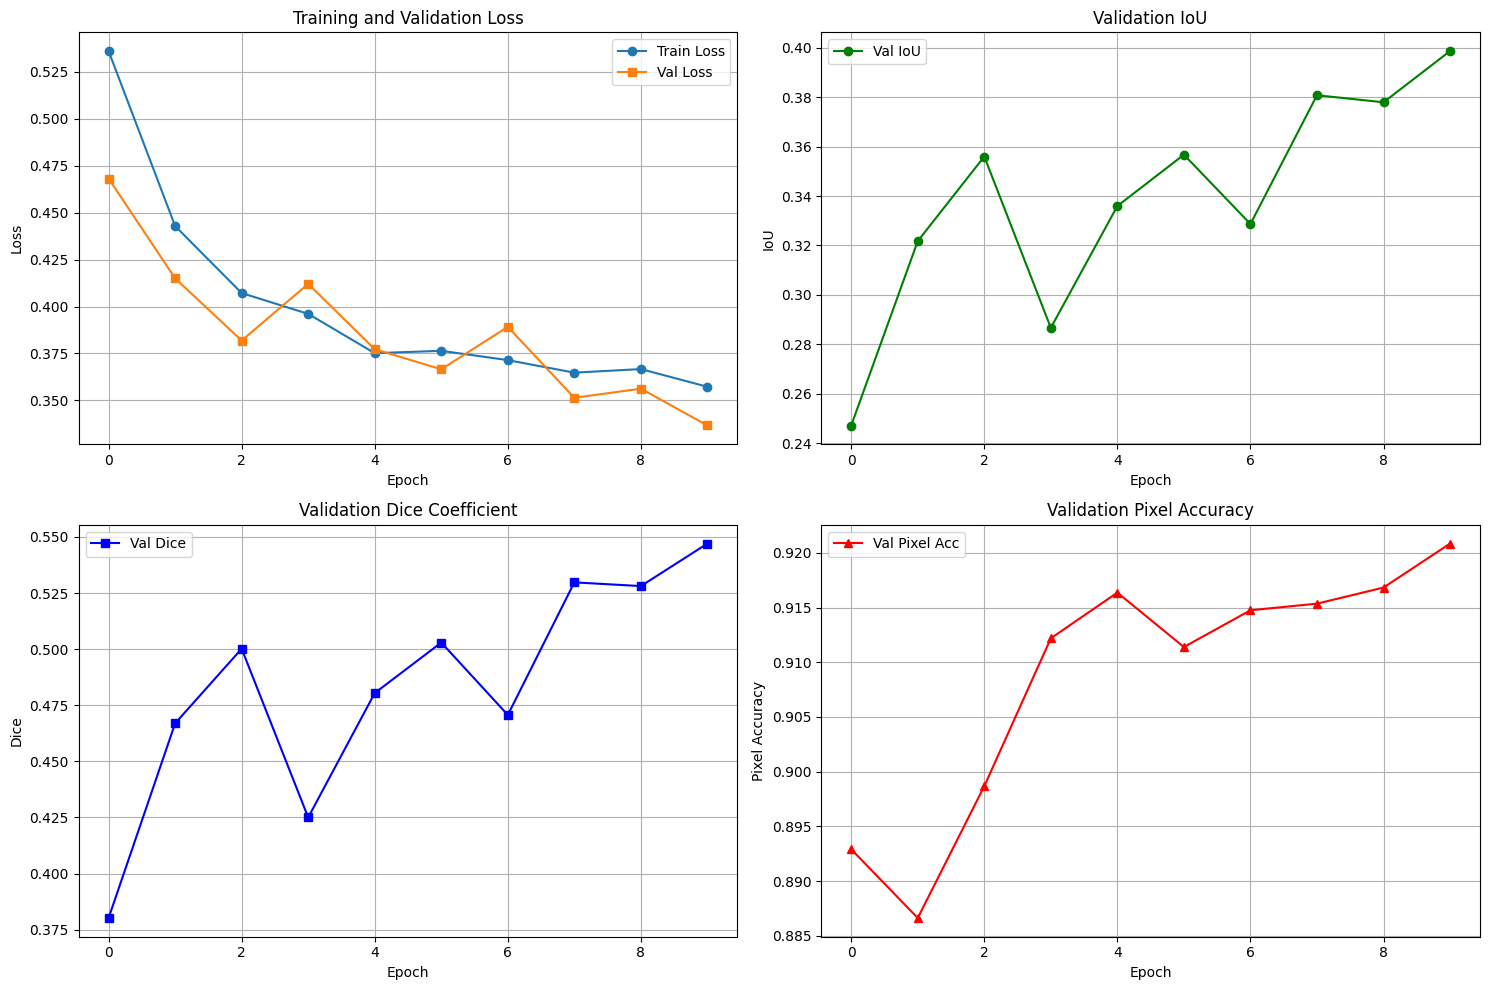

Best model loaded from epoch 10
Best validation IoU: 0.3987
Best validation Dice: 0.5471
Best validation Pixel Acc: 0.9209


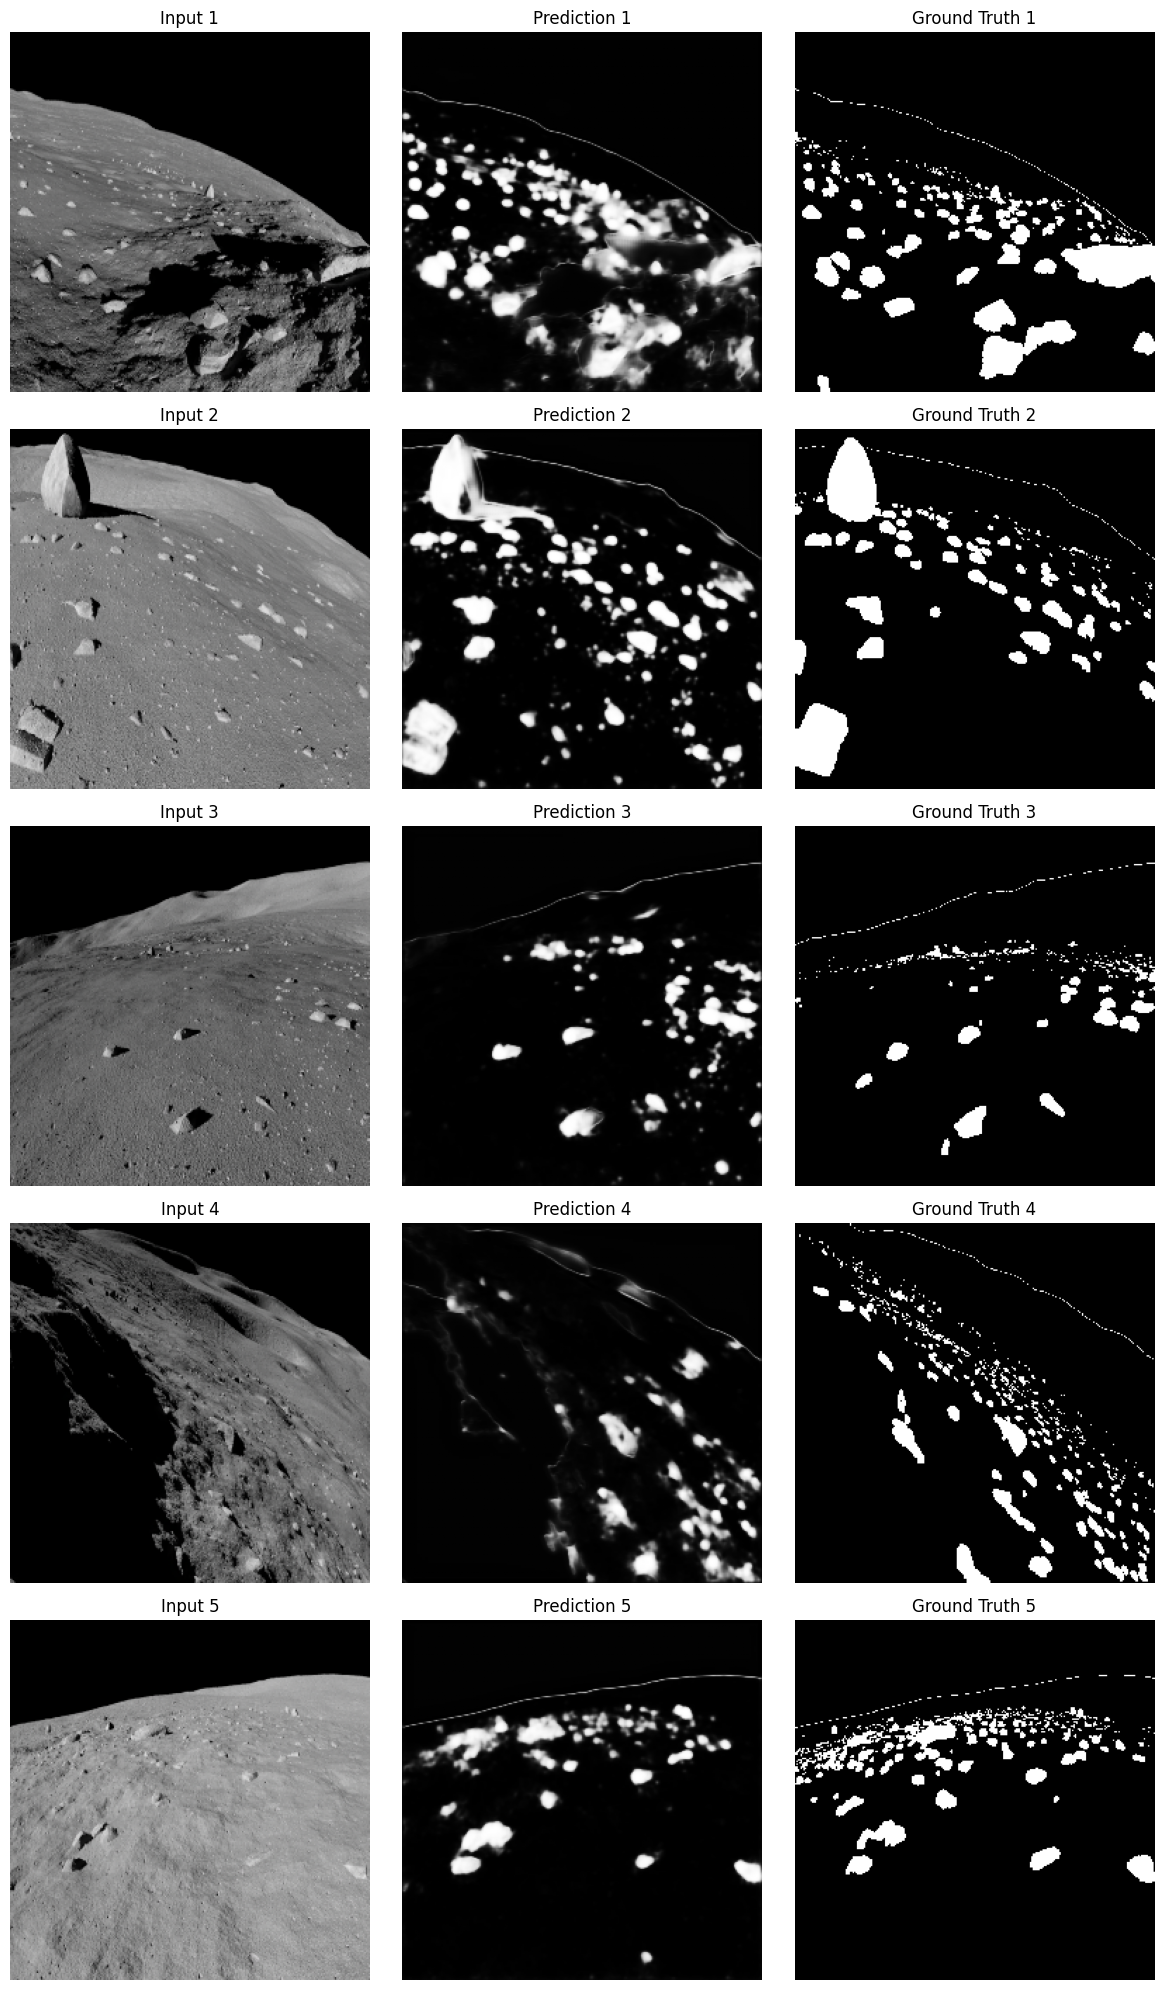

Final evaluation: 100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


=== Part 2 Summary (Basic U-Net) ===
Best validation IoU: 0.3987
Best validation Dice: 0.5471
Best validation Pixel Acc: 0.9209
Final validation IoU: 0.3987
Final validation Dice: 0.5471
Final validation Pixel Acc: 0.9209


In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history_unet_basic['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history_unet_basic['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history_unet_basic['val_iou'], label='Val IoU', marker='o', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('IoU')
axes[0, 1].set_title('Validation IoU')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history_unet_basic['val_dice'], label='Val Dice', marker='s', color='blue')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice')
axes[1, 0].set_title('Validation Dice Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history_unet_basic['val_pixel_acc'], label='Val Pixel Acc', marker='^', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pixel Accuracy')
axes[1, 1].set_title('Validation Pixel Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

checkpoint_unet = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_basic.pth'))
model.load_state_dict(checkpoint_unet['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint_unet['epoch']+1}")
print(f"Best validation IoU: {checkpoint_unet['val_iou']:.4f}")
print(f"Best validation Dice: {checkpoint_unet['val_dice']:.4f}")
print(f"Best validation Pixel Acc: {checkpoint_unet['val_pixel_acc']:.4f}")

model.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i*10]
        img_tensor = img.unsqueeze(0).to(device)

        output = model(img_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu()

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Ground Truth {i+1}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

model.eval()
final_iou = 0.0
final_dice = 0.0
final_pixel_acc = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc='Final evaluation'):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(outputs.size(0)):
            final_iou += calculate_iou(outputs[i], masks[i])
            final_dice += calculate_dice(outputs[i], masks[i])
            final_pixel_acc += calculate_pixel_accuracy(outputs[i], masks[i])
            num_samples += 1

final_iou /= num_samples
final_dice /= num_samples
final_pixel_acc /= num_samples

print('\n=== Part 2 Summary (Basic U-Net) ===')
print(f'Best validation IoU: {checkpoint_unet["val_iou"]:.4f}')
print(f'Best validation Dice: {checkpoint_unet["val_dice"]:.4f}')
print(f'Best validation Pixel Acc: {checkpoint_unet["val_pixel_acc"]:.4f}')
print(f'Final validation IoU: {final_iou:.4f}')
print(f'Final validation Dice: {final_dice:.4f}')
print(f'Final validation Pixel Acc: {final_pixel_acc:.4f}')

<a id='part3'></a>
## Часть 3: U-Net с бэкбоном из классификатора

### 3.1 Адаптация энкодера классификатора

In [40]:
class EncoderFromClassifier(nn.Module):
    def __init__(self, classifier_model):
        super(EncoderFromClassifier, self).__init__()
        self.stage1 = classifier_model.stage1  # 64x64x64
        self.stage2 = classifier_model.stage2  # 32x32x128
        self.stage3 = classifier_model.stage3  # 16x16x256
        self.stage4 = classifier_model.stage4  # 8x8x512

    def forward(self, x):
        x1 = self.stage1(x)   # 64x64x64
        x2 = self.stage2(x1)  # 32x32x128
        x3 = self.stage3(x2)  # 16x16x256
        x4 = self.stage4(x3)  # 8x8x256
        return [x1, x2, x3, x4]

# Instantiate a new CustomClassifier model
classifier_model_instance = CustomClassifier(num_classes=num_classes, dropout=0.1).to(device)

# Load the classifier checkpoint into the new CustomClassifier instance
classifier_checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, 'best_classifier.pth'))
classifier_model_instance.load_state_dict(classifier_checkpoint['model_state_dict'])
print(f"Classifier loaded from epoch {classifier_checkpoint['epoch']+1}")

encoder_from_classifier = EncoderFromClassifier(classifier_model_instance)

dummy_input = torch.randn(2, 3, 128, 128).to(device)
encoder_features = encoder_from_classifier(dummy_input)
print('\nEncoder feature maps:')
for i, feat in enumerate(encoder_features):
    print(f'  Level {i+1}: {feat.shape}')

Classifier loaded from epoch 10

Encoder feature maps:
  Level 1: torch.Size([2, 32, 64, 64])
  Level 2: torch.Size([2, 64, 32, 32])
  Level 3: torch.Size([2, 128, 16, 16])
  Level 4: torch.Size([2, 256, 8, 8])


### 3.2 U-Net с предобученным бэкбоном

In [58]:
class UNetWithBackbone(nn.Module):

    def __init__(self, encoder_from_classifier, out_channels=1, pretrained=True):
        super(UNetWithBackbone, self).__init__()

        self.encoder1 = encoder_from_classifier.stage1 # Out: 32 channels, 64x64
        self.encoder2 = encoder_from_classifier.stage2 # Out: 64 channels, 32x32
        self.encoder3 = encoder_from_classifier.stage3 # Out: 128 channels, 16x16
        self.encoder4 = encoder_from_classifier.stage4 # Out: 256 channels, 8x8

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # Output: 128 channels, 16x16
        self.decoder4 = DoubleConv(128 + 128, 128) # Output: 128 channels, 16x16

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # Output: 64 channels, 32x32
        self.decoder3 = DoubleConv(64 + 64, 64) # Output: 64 channels, 32x32

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # Output: 32 channels, 64x64
        self.decoder2 = DoubleConv(32 + 32, 32) # Output: 32 channels, 64x64

        self.upconv1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # Output: 32 channels, 128x128
        self.decoder1 = DoubleConv(32, 32) # Output: 32 channels, 128x128

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # (B, 32, 64, 64)
        enc2 = self.encoder2(enc1) # (B, 64, 32, 32)
        enc3 = self.encoder3(enc2) # (B, 128, 16, 16)
        enc4 = self.encoder4(enc3) # (B, 256, 8, 8)

        x = self.upconv4(enc4) # (B, 128, 16, 16)
        x = torch.cat([x, enc3], dim=1) # (B, 128+128=256, 16, 16)
        x = self.decoder4(x) # (B, 128, 16, 16)

        x = self.upconv3(x) # (B, 64, 32, 32)
        x = torch.cat([x, enc2], dim=1) # (B, 64+64=128, 32, 32)
        x = self.decoder3(x) # (B, 64, 32, 32)

        x = self.upconv2(x) # (B, 32, 64, 64)
        x = torch.cat([x, enc1], dim=1) # (B, 32+32=64, 64, 64)
        x = self.decoder2(x) # (B, 32, 64, 64)

        x = self.upconv1(x) # (B, 32, 128, 128)
        x = self.decoder1(x) # (B, 32, 128, 128)

        out = self.out_conv(x) # (B, out_channels, 128, 128)
        return out

    def freeze_encoder(self):
        for param in self.encoder1.parameters(): param.requires_grad = False
        for param in self.encoder2.parameters(): param.requires_grad = False
        for param in self.encoder3.parameters(): param.requires_grad = False
        for param in self.encoder4.parameters(): param.requires_grad = False
        print('Encoder frozen')

    def unfreeze_encoder(self):
        for param in self.encoder1.parameters(): param.requires_grad = True
        for param in self.encoder2.parameters(): param.requires_grad = True
        for param in self.encoder3.parameters(): param.requires_grad = True
        for param in self.encoder4.parameters(): param.requires_grad = True
        print('Encoder unfrozen')

unet_with_backbone = UNetWithBackbone(encoder_from_classifier, out_channels=1, pretrained=True).to(device)

total_params_backbone = sum(p.numel() for p in unet_with_backbone.parameters())
trainable_params_backbone = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)

print(f'\nU-Net with Backbone parameters: {total_params_backbone:,} ({total_params_backbone/1e6:.2f}M)')
print(f'Trainable parameters: {trainable_params_backbone:,} ({trainable_params_backbone/1e6:.2f}M)')

dummy_input = torch.randn(2, 3, 128, 128).to(device) # Changed input size to 128x128
dummy_output = unet_with_backbone(dummy_input)
print(f'\nInput shape: {dummy_input.shape}')
print(f'Output shape: {dummy_output.shape}')


U-Net with Backbone parameters: 2,738,369 (2.74M)
Trainable parameters: 2,738,369 (2.74M)

Input shape: torch.Size([2, 3, 128, 128])
Output shape: torch.Size([2, 1, 128, 128])


### 3.3 Обучение с замороженным энкодером

In [59]:
unet_with_backbone.freeze_encoder()

trainable_params_frozen = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)
print(f'Trainable parameters (frozen encoder): {trainable_params_frozen:,} ({trainable_params_frozen/1e6:.2f}M)')

history_frozen = train_unet(unet_with_backbone, train_loader, val_loader,
                            num_epochs=10, lr=0.001, model_name='unet_frozen')

Encoder frozen
Trainable parameters (frozen encoder): 776,993 (0.78M)


Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Epoch 1/10:
  Train Loss: 0.6126
  Val Loss: 0.5358
  Val IoU: 0.2501, Dice: 0.3768, Pixel Acc: 0.8801
  LR: 0.001000
Best model saved! (Val IoU: 0.2501)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  6.87it/s]


Epoch 2/10:
  Train Loss: 0.5000
  Val Loss: 0.5297
  Val IoU: 0.2472, Dice: 0.3764, Pixel Acc: 0.8240
  LR: 0.001000



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


Epoch 3/10:
  Train Loss: 0.4594
  Val Loss: 0.4527
  Val IoU: 0.2352, Dice: 0.3621, Pixel Acc: 0.9012
  LR: 0.001000



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Epoch 4/10:
  Train Loss: 0.4336
  Val Loss: 0.4162
  Val IoU: 0.2793, Dice: 0.4117, Pixel Acc: 0.9009
  LR: 0.001000
Best model saved! (Val IoU: 0.2793)



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Epoch 5/10:
  Train Loss: 0.4248
  Val Loss: 0.4128
  Val IoU: 0.2740, Dice: 0.4041, Pixel Acc: 0.9048
  LR: 0.001000



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Epoch 6/10:
  Train Loss: 0.4203
  Val Loss: 0.4295
  Val IoU: 0.2843, Dice: 0.4202, Pixel Acc: 0.8746
  LR: 0.001000
Best model saved! (Val IoU: 0.2843)



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


Epoch 7/10:
  Train Loss: 0.4167
  Val Loss: 0.4008
  Val IoU: 0.3025, Dice: 0.4408, Pixel Acc: 0.8941
  LR: 0.001000
Best model saved! (Val IoU: 0.3025)



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Epoch 8/10:
  Train Loss: 0.4126
  Val Loss: 0.4014
  Val IoU: 0.2976, Dice: 0.4332, Pixel Acc: 0.8948
  LR: 0.001000



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Epoch 9/10:
  Train Loss: 0.4097
  Val Loss: 0.4069
  Val IoU: 0.2876, Dice: 0.4202, Pixel Acc: 0.9023
  LR: 0.001000



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]

Epoch 10/10:
  Train Loss: 0.4099
  Val Loss: 0.4006
  Val IoU: 0.3072, Dice: 0.4457, Pixel Acc: 0.8894
  LR: 0.001000
Best model saved! (Val IoU: 0.3072)



### 3.4 Fine-tuning с разморозкой энкодера

In [60]:
checkpoint_frozen = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_frozen.pth'))
unet_with_backbone.load_state_dict(checkpoint_frozen['model_state_dict'])
print(f"Best frozen model loaded from epoch {checkpoint_frozen['epoch']+1}")
print(f"Best validation IoU (frozen): {checkpoint_frozen['val_iou']:.4f}")

unet_with_backbone.unfreeze_encoder()

trainable_params_unfrozen = sum(p.numel() for p in unet_with_backbone.parameters() if p.requires_grad)
print(f'Trainable parameters (unfrozen encoder): {trainable_params_unfrozen:,} ({trainable_params_unfrozen/1e6:.2f}M)')

print('\n=== Fine-tuning U-Net with Unfrozen Encoder ===')
history_finetuned = train_unet(unet_with_backbone, train_loader, val_loader,
                               num_epochs=10, lr=0.0001, model_name='unet_finetuned')
print('Fine-tuning complete!')

Best frozen model loaded from epoch 10
Best validation IoU (frozen): 0.3072
Encoder unfrozen
Trainable parameters (unfrozen encoder): 2,738,369 (2.74M)

=== Fine-tuning U-Net with Unfrozen Encoder ===


Epoch 1/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Epoch 1/10:
  Train Loss: 0.4027
  Val Loss: 0.3935
  Val IoU: 0.2999, Dice: 0.4354, Pixel Acc: 0.9035
  LR: 0.000100
Best model saved! (Val IoU: 0.2999)



Epoch 2/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Epoch 2/10:
  Train Loss: 0.3953
  Val Loss: 0.3876
  Val IoU: 0.3103, Dice: 0.4473, Pixel Acc: 0.9011
  LR: 0.000100
Best model saved! (Val IoU: 0.3103)



Epoch 3/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Epoch 3/10:
  Train Loss: 0.3922
  Val Loss: 0.3864
  Val IoU: 0.3124, Dice: 0.4488, Pixel Acc: 0.8974
  LR: 0.000100
Best model saved! (Val IoU: 0.3124)



Epoch 4/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Epoch 4/10:
  Train Loss: 0.3945
  Val Loss: 0.3796
  Val IoU: 0.3124, Dice: 0.4479, Pixel Acc: 0.9067
  LR: 0.000100
Best model saved! (Val IoU: 0.3124)



Epoch 5/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Epoch 5/10:
  Train Loss: 0.3897
  Val Loss: 0.3831
  Val IoU: 0.3091, Dice: 0.4441, Pixel Acc: 0.9071
  LR: 0.000100



Epoch 6/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Epoch 6/10:
  Train Loss: 0.3904
  Val Loss: 0.3808
  Val IoU: 0.3142, Dice: 0.4504, Pixel Acc: 0.9058
  LR: 0.000100
Best model saved! (Val IoU: 0.3142)



Epoch 7/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Epoch 7/10:
  Train Loss: 0.3873
  Val Loss: 0.3923
  Val IoU: 0.3042, Dice: 0.4389, Pixel Acc: 0.9062
  LR: 0.000100



Epoch 8/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Epoch 8/10:
  Train Loss: 0.3924
  Val Loss: 0.3766
  Val IoU: 0.3197, Dice: 0.4564, Pixel Acc: 0.9065
  LR: 0.000100
Best model saved! (Val IoU: 0.3197)



Epoch 9/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


Epoch 9/10:
  Train Loss: 0.3910
  Val Loss: 0.3863
  Val IoU: 0.3070, Dice: 0.4418, Pixel Acc: 0.9063
  LR: 0.000100



Epoch 10/10 [Val]: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]

Epoch 10/10:
  Train Loss: 0.3844
  Val Loss: 0.3775
  Val IoU: 0.3196, Dice: 0.4563, Pixel Acc: 0.9056
  LR: 0.000100

Fine-tuning complete!


### 3.5 Результаты и визуализация

Best fine-tuned model loaded from epoch 8
Best validation IoU (fine-tuned): 0.3197


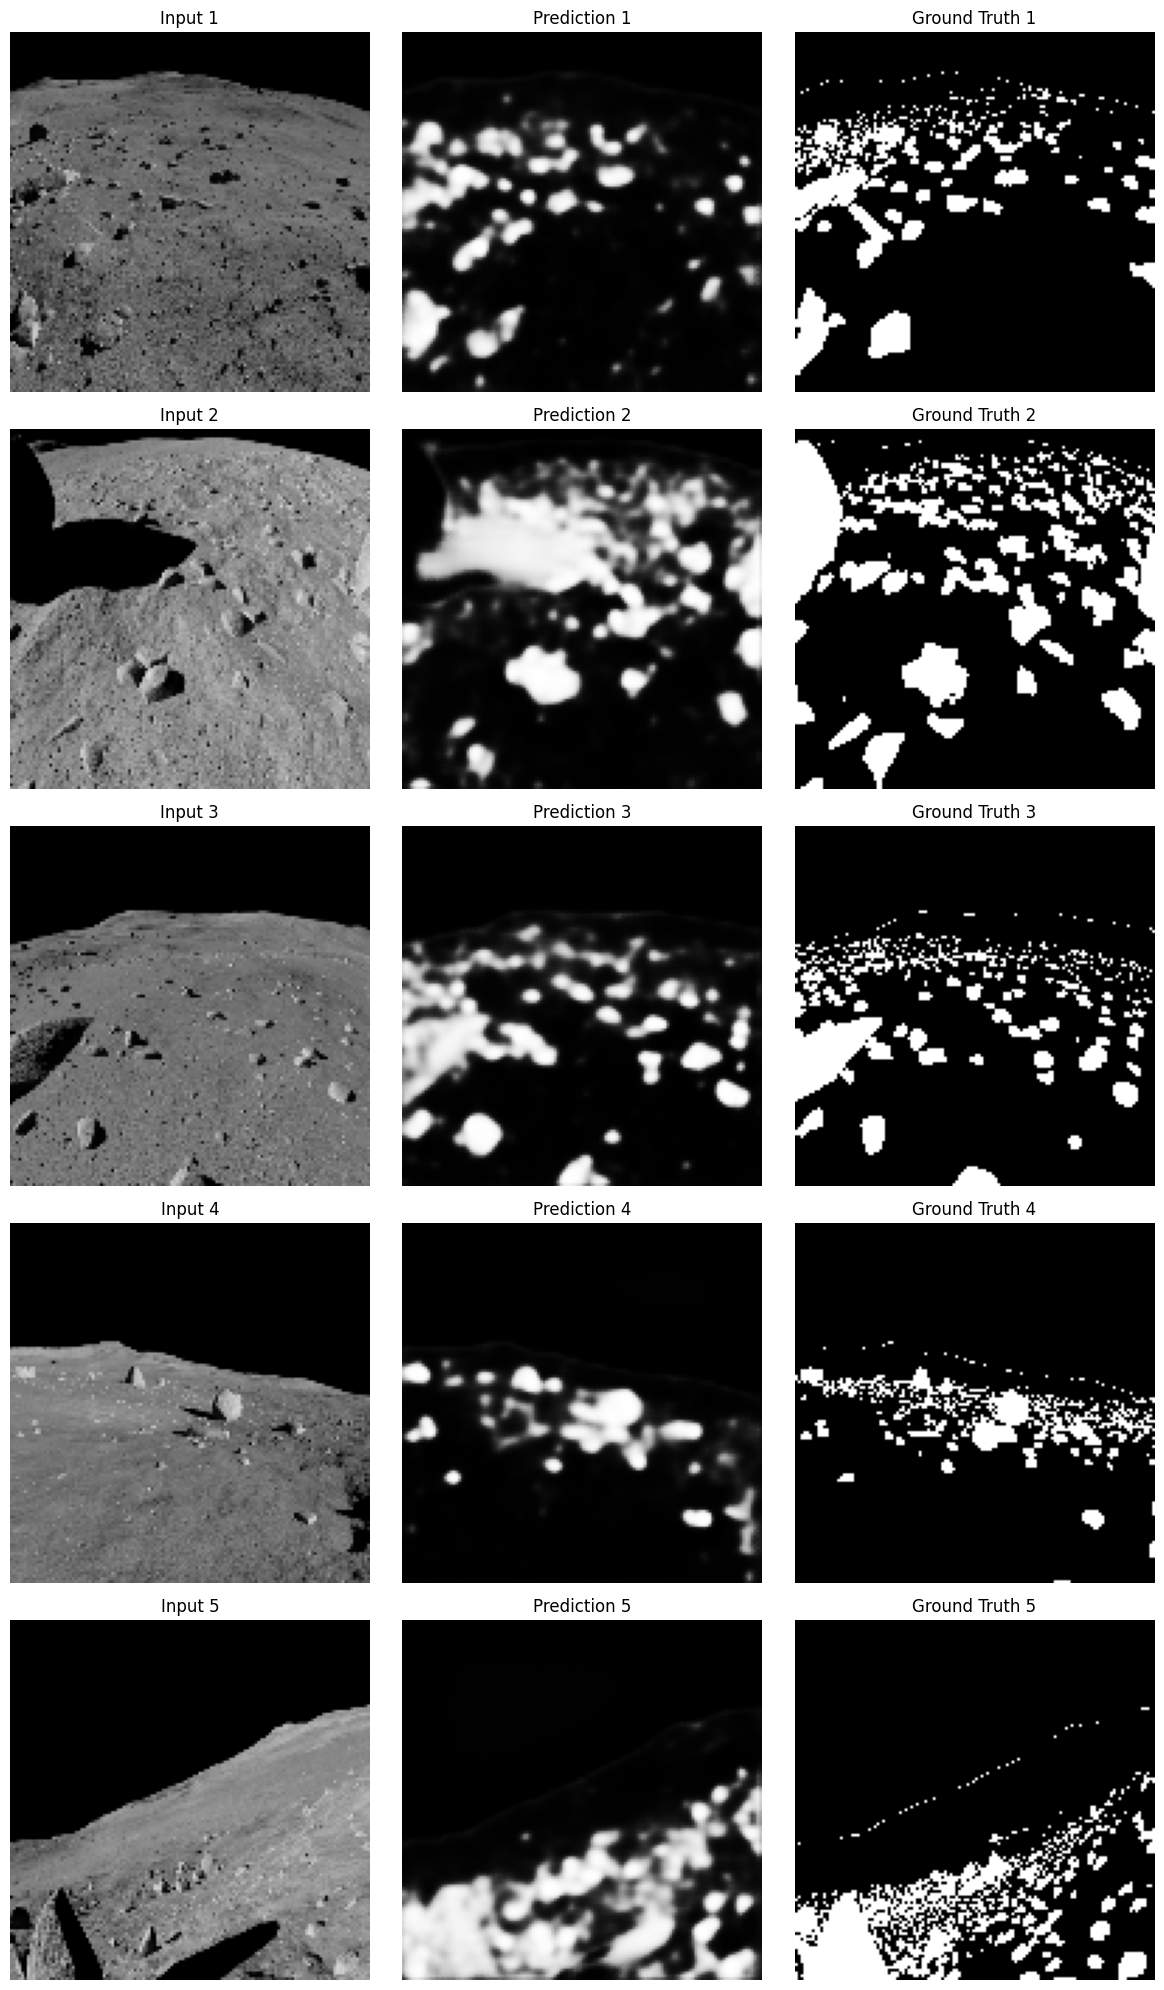

Final evaluation (backbone): 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


=== Part 3 Summary (U-Net with Backbone) ===
Model parameters: 2.74M
Best validation IoU (frozen): 0.3072
Best validation IoU (fine-tuned): 0.3197
Final validation IoU: 0.3197
Final validation Dice: 0.4564
Final validation Pixel Acc: 0.9065


In [61]:
checkpoint_finetuned = torch.load(os.path.join(CHECKPOINT_DIR, 'best_unet_finetuned.pth'))
unet_with_backbone.load_state_dict(checkpoint_finetuned['model_state_dict'])
print(f"Best fine-tuned model loaded from epoch {checkpoint_finetuned['epoch']+1}")
print(f"Best validation IoU (fine-tuned): {checkpoint_finetuned['val_iou']:.4f}")

unet_with_backbone.eval()
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i*10]
        img_tensor = img.unsqueeze(0).to(device)

        output = unet_with_backbone(img_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu()

        img_display = denormalize(img)
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Ground Truth {i+1}')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

unet_with_backbone.eval()
final_iou_backbone = 0.0
final_dice_backbone = 0.0
final_pixel_acc_backbone = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc='Final evaluation (backbone)'):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_with_backbone(images)

        for i in range(outputs.size(0)):
            final_iou_backbone += calculate_iou(outputs[i], masks[i])
            final_dice_backbone += calculate_dice(outputs[i], masks[i])
            final_pixel_acc_backbone += calculate_pixel_accuracy(outputs[i], masks[i])
            num_samples += 1

final_iou_backbone /= num_samples
final_dice_backbone /= num_samples
final_pixel_acc_backbone /= num_samples

print('\n=== Part 3 Summary (U-Net with Backbone) ===')
print(f'Model parameters: {total_params_backbone/1e6:.2f}M')
print(f'Best validation IoU (frozen): {checkpoint_frozen["val_iou"]:.4f}')
print(f'Best validation IoU (fine-tuned): {checkpoint_finetuned["val_iou"]:.4f}')
print(f'Final validation IoU: {final_iou_backbone:.4f}')
print(f'Final validation Dice: {final_dice_backbone:.4f}')
print(f'Final validation Pixel Acc: {final_pixel_acc_backbone:.4f}')

<a id='conclusions'></a>
## Выводы и сравнение результатов

### Сравнительная таблица метрик


COMPARISON TABLE: Basic U-Net vs U-Net with Classifier Backbone
                     Model Parameters (M) Trainable Params (M) Best Val IoU Best Val Dice Best Val Pixel Acc Final Val IoU Final Val Dice Final Val Pixel Acc
               Basic U-Net          31.04                31.04       0.3987        0.5471             0.9209        0.3987         0.5471              0.9209
    U-Net + Frozen Encoder           2.74                 0.78       0.3072        0.4457             0.8894           N/A            N/A                 N/A
U-Net + Fine-tuned Encoder           2.74                 2.74       0.3197        0.4564             0.9065        0.3197         0.4564              0.9065


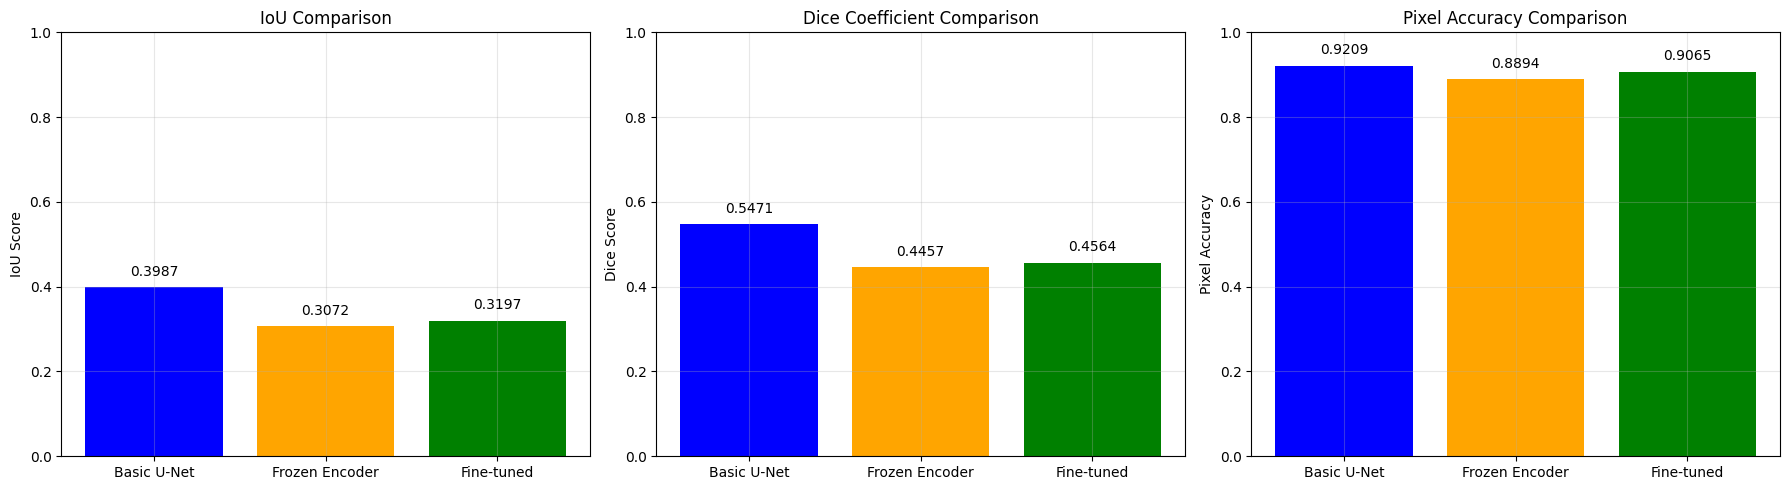

In [65]:
comparison_data = {
    'Model': [
        'Basic U-Net',
        'U-Net + Frozen Encoder',
        'U-Net + Fine-tuned Encoder'
    ],
    'Parameters (M)': [
        f'{total_params_unet/1e6:.2f}',
        f'{total_params_backbone/1e6:.2f}',
        f'{total_params_backbone/1e6:.2f}'
    ],
    'Trainable Params (M)': [
        f'{total_params_unet/1e6:.2f}',
        f'{trainable_params_frozen/1e6:.2f}',
        f'{trainable_params_unfrozen/1e6:.2f}'
    ],
    'Best Val IoU': [
        f'{checkpoint_unet["val_iou"]:.4f}',
        f'{checkpoint_frozen["val_iou"]:.4f}',
        f'{checkpoint_finetuned["val_iou"]:.4f}'
    ],
    'Best Val Dice': [
        f'{checkpoint_unet["val_dice"]:.4f}',
        f'{checkpoint_frozen["val_dice"]:.4f}',
        f'{checkpoint_finetuned["val_dice"]:.4f}'
    ],
    'Best Val Pixel Acc': [
        f'{checkpoint_unet["val_pixel_acc"]:.4f}',
        f'{checkpoint_frozen["val_pixel_acc"]:.4f}',
        f'{checkpoint_finetuned["val_pixel_acc"]:.4f}'
    ],
    'Final Val IoU': [
        f'{final_iou:.4f}',
        'N/A',
        f'{final_iou_backbone:.4f}'
    ],
    'Final Val Dice': [
        f'{final_dice:.4f}',
        'N/A',
        f'{final_dice_backbone:.4f}'
    ],
    'Final Val Pixel Acc': [
        f'{final_pixel_acc:.4f}',
        'N/A',
        f'{final_pixel_acc_backbone:.4f}'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print('\n' + '='*80)
print('COMPARISON TABLE: Basic U-Net vs U-Net with Classifier Backbone')
print('='*80)
print(df_comparison.to_string(index=False))
print('='*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Basic U-Net', 'Frozen Encoder', 'Fine-tuned']
iou_scores = [
    checkpoint_unet["val_iou"],
    checkpoint_frozen["val_iou"],
    checkpoint_finetuned["val_iou"]
]
dice_scores = [
    checkpoint_unet["val_dice"],
    checkpoint_frozen["val_dice"],
    checkpoint_finetuned["val_dice"]
]
pixel_acc_scores = [
    checkpoint_unet["val_pixel_acc"],
    checkpoint_frozen["val_pixel_acc"],
    checkpoint_finetuned["val_pixel_acc"]
]

axes[0].bar(models, iou_scores, color=['blue', 'orange', 'green'])
axes[0].set_ylabel('IoU Score')
axes[0].set_title('IoU Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(iou_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

axes[1].bar(models, dice_scores, color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Dice Coefficient Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(dice_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

axes[2].bar(models, pixel_acc_scores, color=['blue', 'orange', 'green'])
axes[2].set_ylabel('Pixel Accuracy')
axes[2].set_title('Pixel Accuracy Comparison')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3)
for i, v in enumerate(pixel_acc_scores):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Итоговые выводы

Конкретно в данном случае лучше всего себя показала обычная U-NET, что можно объяснить:
- Разным доменом при обучении классификтора и при обучении UNET
- Коротким временем обучения (к сожалению в силу близкого дедлайна и ограниченного доступа к GPU получилось только так)